In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import math
from functions import *
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

import gc; gc.enable()

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
data = pd.read_csv('./data/data.csv')

In [3]:
data=data.rename(columns = {"Unnamed: 0": "Date"})

In [4]:
data.tail()

,Date,Load,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,N.Y.C._LONGIL
146659,2017-04-24 19:00:00,16984.175000,1291.972222,1768.647222,654.152778,1058.680556,1062.383333,2238.380556,855.547222,289.441667,5559.388889,487.286111,1718.294444,NaN
146660,2017-04-24 20:00:00,17615.657540,1341.735714,1843.365873,683.256349,1108.247222,1122.049603,2388.324206,884.457540,311.366270,5647.025397,498.217460,1787.611905,NaN
146661,2017-04-24 21:00:00,17200.752778,1290.469444,1801.922222,675.925000,1091.652778,1086.563889,2318.411111,846.966667,290.966667,5521.511111,492.600000,1783.763889,NaN
146662,2017-04-24 22:00:00,16148.388889,1193.955556,1687.572222,641.322222,1011.200000,1007.902778,2140.886111,776.563889,258.008333,5256.850000,475.905556,1698.222222,NaN
146663,2017-04-24 23:00:00,14931.883333,1092.930556,1577.530556,583.055556,933.863889,920.994444,1937.283333,699.247222,231.258333,4895.633333,460.969444,1599.116667,NaN


In [5]:
data.Date = pd.to_datetime(data.Date)

In [6]:
data.set_index('Date', inplace = True)

In [7]:
data.sort_index(inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146664 entries, 2003-01-01 00:00:00 to 2019-08-31 23:00:00
Data columns (total 13 columns):
Load             146034 non-null float64
CAPITL           146034 non-null float64
CENTRL           146034 non-null float64
DUNWOD           146034 non-null float64
GENESE           146034 non-null float64
HUD VL           146034 non-null float64
LONGIL           127809 non-null float64
MHK VL           146034 non-null float64
MILLWD           146034 non-null float64
N.Y.C.           127809 non-null float64
NORTH            146034 non-null float64
WEST             146034 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 15.7 MB


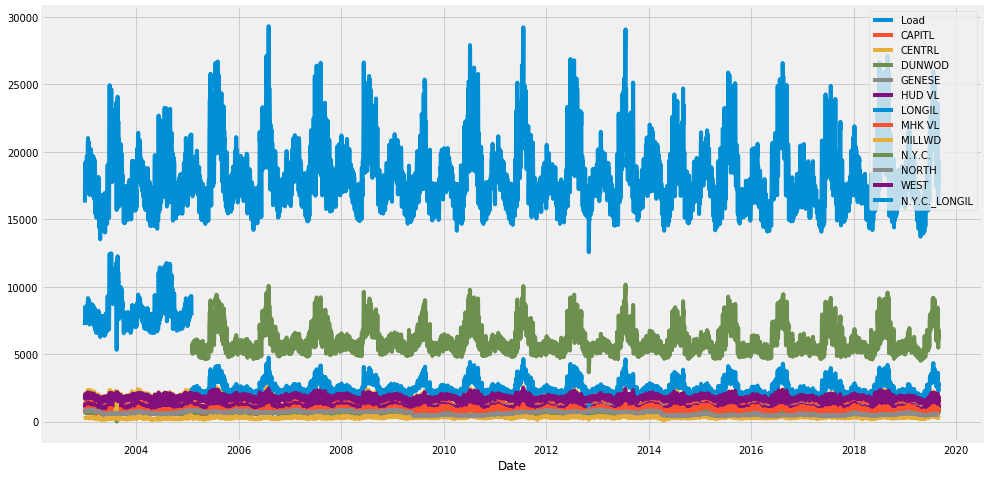

In [9]:
days = data.resample("D")
days_=days.mean()
days_.plot(kind = 'line', figsize=(15, 8))
plt.show()

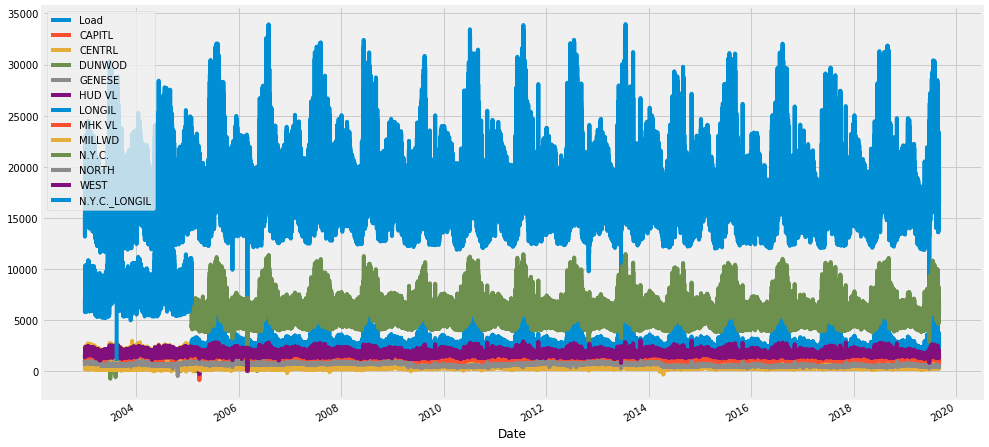

In [10]:
data.plot(kind = 'line', figsize=(15, 8))
plt.show()

In [11]:
data.tail()

,Load,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,N.Y.C._LONGIL
Date,,,,,,,,,,,,,
2019-08-31 19:00:00,18978.866667,1432.041667,1704.391667,755.041667,1045.016667,1219.691667,3035.408333,890.116667,343.716667,6431.391667,518.683333,1603.366667,NaN
2019-08-31 20:00:00,18835.633333,1444.800000,1701.433333,747.925000,1050.491667,1205.100000,2950.483333,894.091667,339.916667,6391.741667,491.141667,1618.508333,NaN
2019-08-31 21:00:00,18256.466667,1398.208333,1639.766667,728.100000,1008.441667,1142.266667,2787.541667,868.941667,330.808333,6281.708333,492.925000,1577.758333,NaN
2019-08-31 22:00:00,17426.316667,1318.433333,1554.750000,694.583333,952.525000,1066.483333,2598.775000,815.766667,311.116667,6107.491667,485.675000,1520.716667,NaN
2019-08-31 23:00:00,16364.112500,1225.181250,1441.912500,651.893750,888.337500,980.656250,2389.050000,746.581250,277.956250,5860.143750,488.106250,1414.293750,NaN


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146664 entries, 2003-01-01 00:00:00 to 2019-08-31 23:00:00
Data columns (total 13 columns):
Load             146034 non-null float64
CAPITL           146034 non-null float64
CENTRL           146034 non-null float64
DUNWOD           146034 non-null float64
GENESE           146034 non-null float64
HUD VL           146034 non-null float64
LONGIL           127809 non-null float64
MHK VL           146034 non-null float64
MILLWD           146034 non-null float64
N.Y.C.           127809 non-null float64
NORTH            146034 non-null float64
WEST             146034 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 20.7 MB


In [13]:
data.isna().sum()

Load                630
CAPITL              630
CENTRL              630
DUNWOD              630
GENESE              630
HUD VL              630
LONGIL            18855
MHK VL              630
MILLWD              630
N.Y.C.            18855
NORTH               630
WEST                630
N.Y.C._LONGIL    128439
dtype: int64

In [14]:
#drop NaNs
target = 'Load'
data.dropna(subset = [target], inplace=True)
data.isna().sum()

Load                  0
CAPITL                0
CENTRL                0
DUNWOD                0
GENESE                0
HUD VL                0
LONGIL            18225
MHK VL                0
MILLWD                0
N.Y.C.            18225
NORTH                 0
WEST                  0
N.Y.C._LONGIL    127809
dtype: int64

In [15]:
data.shape

(146034, 13)

In [16]:
drop_cols = [col for col in data.columns.tolist() if col not in [target]]

In [17]:
data.drop(drop_cols, axis=1, inplace=True)

In [18]:
data.head()

,Load
Date,
2003-01-01 00:00:00,15415.625000
2003-01-01 01:00:00,14569.928571
2003-01-01 02:00:00,13812.200000
2003-01-01 03:00:00,13315.333333
2003-01-01 04:00:00,13156.333333


In [19]:
df_ = data['01-01-2017':'07-31-2019'].copy()

In [129]:
df_.shape

(13845, 56)

In [20]:
df_ = create_features(df_, target)

In [21]:
df_.dropna(inplace=True)

In [22]:
df_.head()

,Load,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,lag_365,pct_365,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,18942.233333,2018-01-01 01:00:00,1,0,1,1,2018,1,1,1,...,15763.208333,0.832173,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 02:00:00,18469.283333,2018-01-01 02:00:00,2,0,1,1,2018,1,1,1,...,15071.408333,0.816026,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 03:00:00,18163.875000,2018-01-01 03:00:00,3,0,1,1,2018,1,1,1,...,14485.033333,0.797464,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 04:00:00,18009.541667,2018-01-01 04:00:00,4,0,1,1,2018,1,1,1,...,14097.658333,0.782788,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 05:00:00,18158.241667,2018-01-01 05:00:00,5,0,1,1,2018,1,1,1,...,13937.300000,0.767547,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16


In [23]:
df_.tail()

,Load,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,lag_365,pct_365,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-31 19:00:00,24835.000000,2019-07-31 19:00:00,19,2,3,7,2019,212,31,31,...,24804.641667,0.998778,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 20:00:00,24219.675000,2019-07-31 20:00:00,20,2,3,7,2019,212,31,31,...,24019.750000,0.991745,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 21:00:00,23578.041667,2019-07-31 21:00:00,21,2,3,7,2019,212,31,31,...,23664.100000,1.003650,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 22:00:00,22177.316667,2019-07-31 22:00:00,22,2,3,7,2019,212,31,31,...,23159.708333,1.044297,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 23:00:00,20562.291667,2019-07-31 23:00:00,23,2,3,7,2019,212,31,31,...,21818.275000,1.061082,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268


In [24]:
train, test = split_data(df_, '06-01-2019')

In [25]:
y = train[target].shift(-(24*7)).dropna()

In [26]:
_id = 'date'
train, keep_cols, used_cols = data_prep(train, target, _id)

In [27]:
X = train[used_cols].iloc[:-(24*7),:]

In [28]:
X.shape

(12213, 54)

In [29]:
y.shape

(12213,)

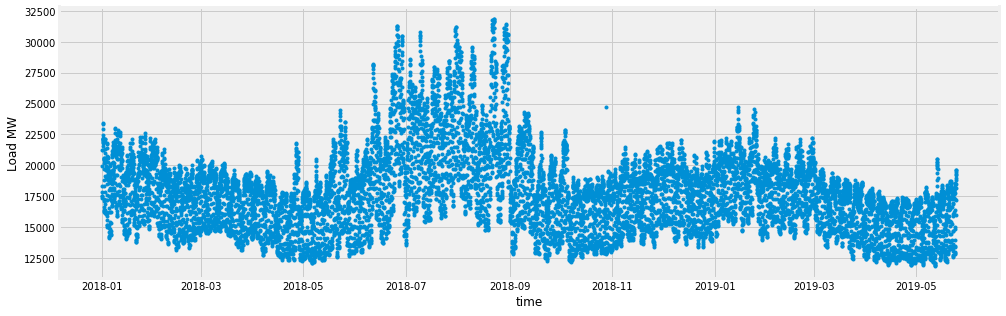

In [30]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('Load MW')
plt.plot(X.index,y, '.')
# plt.plot(X_test.index,y_test, '.')
plt.show()

In [31]:
reg = xgb.XGBRegressor()

In [32]:
reg.fit(X, y, 
        eval_set=[(X, y)],
        eval_metric = 'mae',
        early_stopping_rounds=25, 
        verbose=False) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [33]:
# evals_result = reg.evals_result()

In [34]:
# evals_result

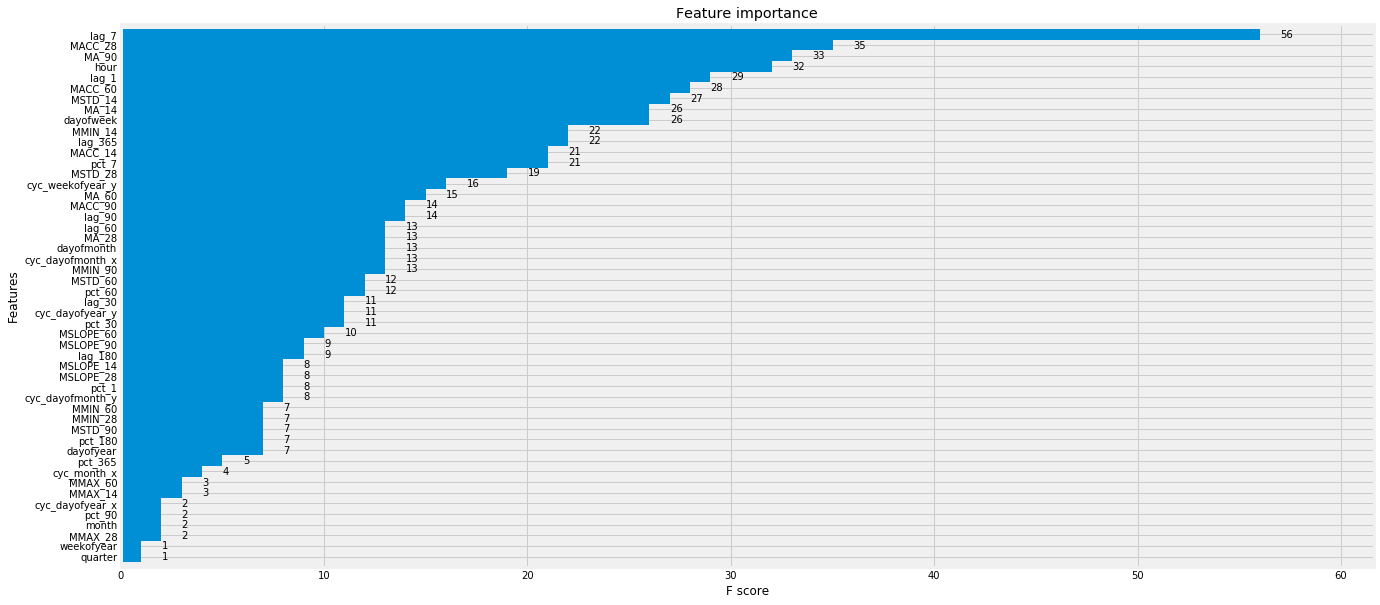

In [35]:
plt.rcParams["figure.figsize"] = (20, 10)
xgb.plot_importance(reg, height = 1)

In [36]:
test, keep_cols, used_cols = data_prep(test, target, _id, isTest=True)


In [37]:
y_pred = reg.predict(test[used_cols])
y_pred.shape

(1464,)

In [38]:
y_test = data['06-02-2019':'08-01-2019'][target].copy()

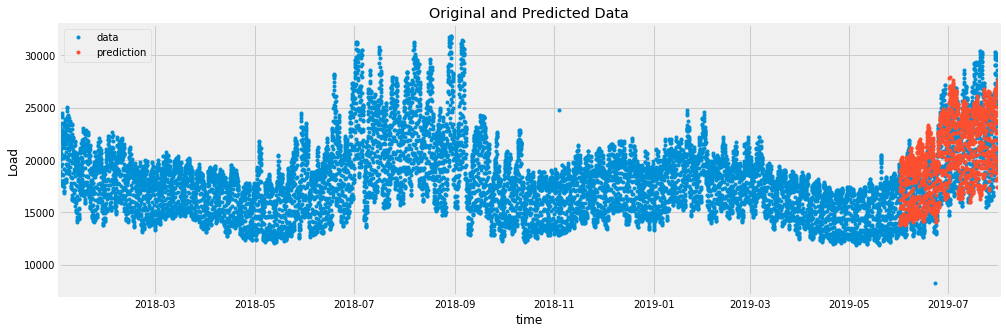

In [39]:
plt.figure(figsize=(15,5))
plt.title('Original and Predicted Data')
plt.xlabel('time')
plt.ylabel('Load')
# plt.plot(X.index, y, '.', label='data')
plt.plot(df_.index, df_[target], '.', label='data')
plt.plot(test.index, y_pred, '.', label='prediction')
plt.legend()
plt.xlim(left=X.index[0], right=test.index[-1])
plt.show()

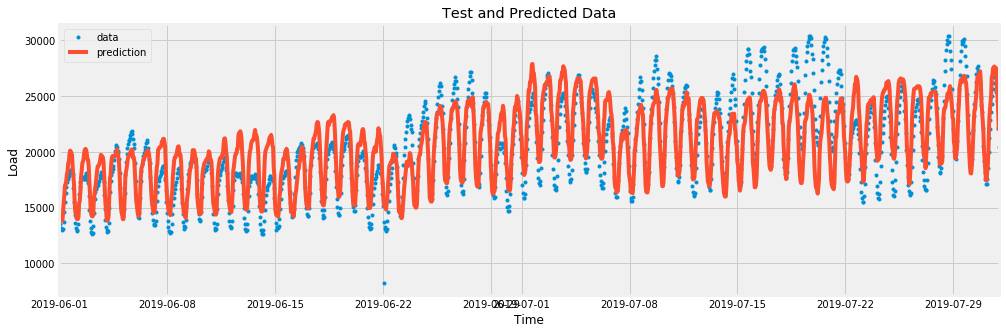

In [40]:
plt.figure(figsize=(15,5))
plt.title('Test and Predicted Data')
plt.xlabel('Time')
plt.ylabel('Load')
plt.plot(test.index, y_test, '.', label='data')
plt.plot(test.index, y_pred, '-', label='prediction')
plt.legend()
plt.xlim(left=test.index[0], right=test.index[-1])
plt.show()
# plot_(test, y_test, test[target].index[0], test[target].index[-1], 'Test and Predicted Data')

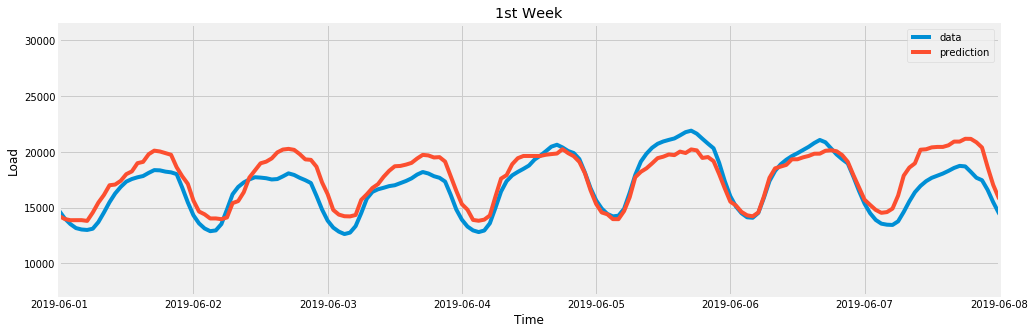

In [41]:
plt.figure(figsize=(15,5))
plt.title('1st Week')
plt.xlabel('Time')
plt.ylabel('Load')
plt.plot(test.index, y_test, '-', label='data')
plt.plot(test.index, y_pred, '-', label='prediction')
plt.legend()
plt.xlim(left='06-01-2019', right='06-08-2019')
plt.show()
# plot_(test, y_test, '06-01-2019', '06-08-2019', "1 week ")

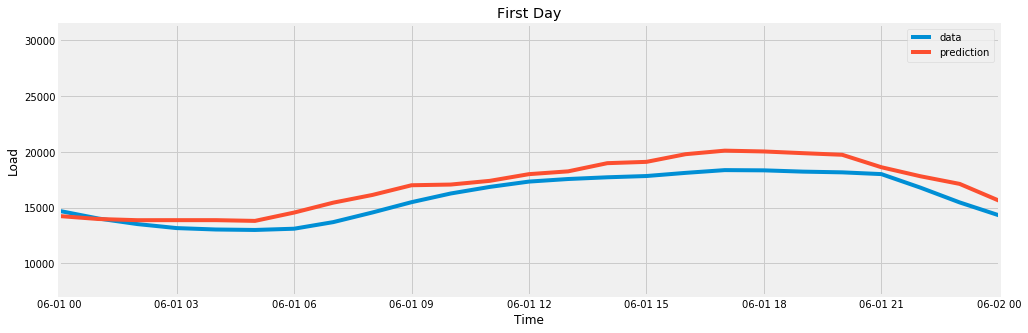

In [42]:
plt.figure(figsize=(15,5))
plt.title('First Day')
plt.xlabel('Time')
plt.ylabel('Load')
plt.plot(test.index, y_test, '-', label='data')
plt.plot(test.index, y_pred, '-', label='prediction')
plt.legend()
plt.xlim(left='06-01-2019', right=y_test.index[0])
plt.show()
# plot_(test, y_test, '06-01-2019', y_test.index[0], "1 day ")

In [43]:
MSE = mean_squared_error(y_test, y_pred)
print(MSE)

4373552.764383002


In [44]:
MAE = mean_absolute_error(y_test, y_pred)
print(MAE)

1694.2904259618067


In [45]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
print(MAPE)

8.45344048330275


In [46]:
sMAPE = symmetric_mape(y_test, y_pred)
print(sMAPE)

8.265217718348605


In [47]:
sMAPE = symmetric_mape(y_test[:(24)], y_pred[:(24)])
print(sMAPE)

6.590944276167627


In [48]:
RMSE = np.sqrt(MSE)
print(RMSE)

2091.304082237445


In [49]:
FE = forecast_error(y_test, y_pred)
MFE = mean_forecast_error(FE)
print(MFE)

-360.14559675641567


In [50]:
r_squared = r2_score(y_test, y_pred)
print(r_squared)

0.746265129196502


In [52]:
list_2 = np.zeros(150)
create_split(list_2, 10)

[(0, 15),
 (0, 30),
 (0, 45),
 (0, 60),
 (0, 75),
 (0, 90),
 (0, 105),
 (0, 120),
 (0, 135),
 (0, 150)]

In [55]:
splits = create_split(df_, 10)
smapes=[]
smapes_daily=[]
smape_list = []
smape_list_daily = []
for start, end in splits:
    sample = df_[start:end]
    split_at = int(len(sample) * 0.8)
    train, keep_cols, used_cols = data_prep(sample[:split_at], target, _id)
    X_train = train[used_cols].iloc[:-(24),:]
    y_train = train[target].shift(-(24)).dropna()
    test, keep_cols, used_cols = data_prep(sample[split_at:], target, _id)
    X_test = test[used_cols].iloc[:-(24),:]
    y_test = test[target].shift(-(24)).dropna()
    reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train)],
        eval_metric = 'mae',
        early_stopping_rounds=25, 
        verbose=False)
    y_pred = reg.predict(X_test)
    s = symmetric_mape(y_test, y_pred)
    s_1 = symmetric_mape(y_test[:24], y_pred[:24])
    smape_list.append(s)
    smape_list_daily.append(s_1)
    avg = sum(smape_list)/len(smape_list)
    avg_daily=sum(smape_list_daily)/len(smape_list_daily)
    smapes.append(avg)
    print("SMAPE per fold: ", s, "\n")
    print("SMAPE first day per fold: ",s_1,"\n")
    print("First Day Average : ", avg_daily)
    print("Average : ", avg)
    print("\n")
    

SMAPE per fold:  6.171355660741666 

SMAPE first day per fold:  3.890590544096768 

First Day Average :  3.890590544096768
Average :  6.171355660741666


SMAPE per fold:  5.112171644939314 

SMAPE first day per fold:  2.871854036920741 

First Day Average :  3.3812222905087546
Average :  5.64176365284049


SMAPE per fold:  8.00172248295312 

SMAPE first day per fold:  4.6326644724272725 

First Day Average :  3.7983696844815937
Average :  6.428416596211367


SMAPE per fold:  7.42032125157267 

SMAPE first day per fold:  6.492769921947965 

First Day Average :  4.471969743848186
Average :  6.676392760051693


SMAPE per fold:  9.901438714274525 

SMAPE first day per fold:  2.7224489048020057 

First Day Average :  4.122065576038951
Average :  7.321401950896259


SMAPE per fold:  4.36072634055767 

SMAPE first day per fold:  7.2031362887825185 

First Day Average :  4.635577361496211
Average :  6.827956015839828


SMAPE per fold:  4.373508229319237 

SMAPE first day per fold:  3.675099753

In [62]:
X_test.head(10)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MA_14,MMAX_14,...,lag_365,pct_365,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-07 15:00:00,15,6,2,4,2019,97,7,14,16175.602221,18905.808333,...,16317.250000,1.129889,-1.836970e-16,-1.0,-0.900969,0.433884,0.981178,0.193105,0.222521,0.974928
2019-04-07 16:00:00,16,6,2,4,2019,97,7,14,16172.533173,18905.808333,...,16136.325000,1.091080,-1.836970e-16,-1.0,-0.900969,0.433884,0.981178,0.193105,0.222521,0.974928
2019-04-07 17:00:00,17,6,2,4,2019,97,7,14,16169.794855,18905.808333,...,16349.425000,1.069368,-1.836970e-16,-1.0,-0.900969,0.433884,0.981178,0.193105,0.222521,0.974928
2019-04-07 18:00:00,18,6,2,4,2019,97,7,14,16167.191333,18905.808333,...,16630.358333,1.060857,-1.836970e-16,-1.0,-0.900969,0.433884,0.981178,0.193105,0.222521,0.974928
2019-04-07 19:00:00,19,6,2,4,2019,97,7,14,16163.946492,18905.808333,...,16914.566667,1.045365,-1.836970e-16,-1.0,-0.900969,0.433884,0.981178,0.193105,0.222521,0.974928
2019-04-07 20:00:00,20,6,2,4,2019,97,7,14,16160.858000,18905.808333,...,17417.841667,1.061441,-1.836970e-16,-1.0,-0.900969,0.433884,0.981178,0.193105,0.222521,0.974928
2019-04-07 21:00:00,21,6,2,4,2019,97,7,14,16157.855991,18905.808333,...,17764.041667,1.120439,-1.836970e-16,-1.0,-0.900969,0.433884,0.981178,0.193105,0.222521,0.974928
2019-04-07 22:00:00,22,6,2,4,2019,97,7,14,16154.803362,18905.808333,...,17350.541667,1.162231,-1.836970e-16,-1.0,-0.900969,0.433884,0.981178,0.193105,0.222521,0.974928
2019-04-07 23:00:00,23,6,2,4,2019,97,7,14,16151.706809,18905.808333,...,16696.558333,1.201933,-1.836970e-16,-1.0,-0.900969,0.433884,0.981178,0.193105,0.222521,0.974928


In [57]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MA_14,MMAX_14,...,lag_365,pct_365,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,1,0,1,1,2018,1,1,1,19015.850788,24233.433333,...,15763.208333,0.832173,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 02:00:00,2,0,1,1,2018,1,1,1,19025.425019,24233.433333,...,15071.408333,0.816026,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 03:00:00,3,0,1,1,2018,1,1,1,19034.414752,24233.433333,...,14485.033333,0.797464,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 04:00:00,4,0,1,1,2018,1,1,1,19042.206939,24233.433333,...,14097.658333,0.782788,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16
2018-01-01 05:00:00,5,0,1,1,2018,1,1,1,19047.876756,24233.433333,...,13937.300000,0.767547,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16,1.0,-4.898587e-16


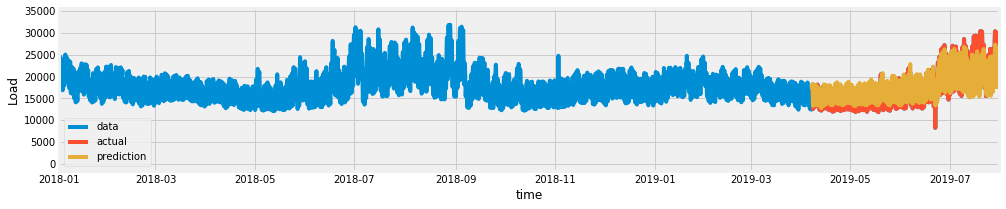

In [58]:
plt.figure(figsize=(15,3))
plt.xlabel('time')
plt.ylabel('Load')
# plt.title("")
plt.plot(data.iloc[:-(24),:].index, data[target].shift(-(24)).dropna(), '-', label='data')
plt.plot(X_test.index, y_test, '-', label='actual')
plt.plot(X_test.index, y_pred, '-', label='prediction')
plt.legend()
plt.xlim(left='01-01-2018', right='07-31-2019')
plt.show()

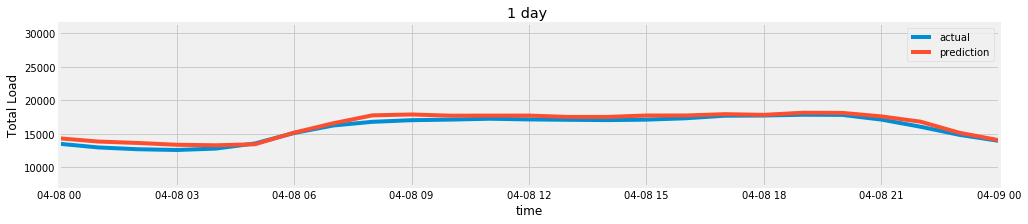

In [59]:
plt.figure(figsize=(15,3))
plt.xlabel('time')
plt.ylabel('Total Load')
plt.title("1 day ")
plt.plot(X_test.index, y_test, '-', label='actual')
plt.plot(X_test.index, y_pred, '-', label='prediction')
plt.legend()
plt.xlim(left='04-08-2019', right='04-09-2019')
plt.show()
# plot_(X_test, y_test, '06-23-2019', y_test.index[48], "1 day ")

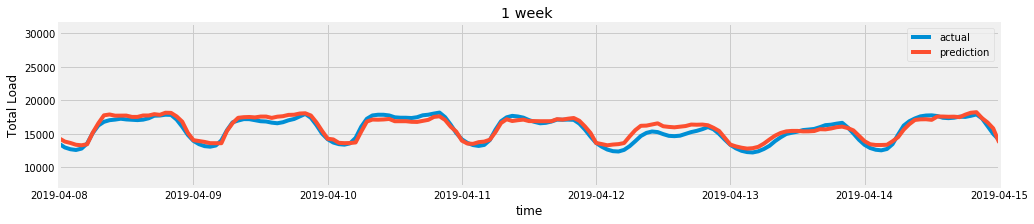

In [60]:
plt.figure(figsize=(15,3))
plt.xlabel('time')
plt.ylabel('Total Load')
plt.title("1 week ")
plt.plot(X_test.index, y_test, '-', label='actual')
plt.plot(X_test.index, y_pred, '-', label='prediction')
plt.legend()
plt.xlim(left='04-08-2019', right='04-15-2019')
plt.show()

In [63]:
y_test

Date
2019-04-07 15:00:00    17058.525000
2019-04-07 16:00:00    17165.316667
2019-04-07 17:00:00    17386.933333
2019-04-07 18:00:00    17390.408333
2019-04-07 19:00:00    17569.483333
2019-04-07 20:00:00    17623.883333
2019-04-07 21:00:00    16842.991667
2019-04-07 22:00:00    15682.108333
2019-04-07 23:00:00    14421.866667
2019-04-08 00:00:00    13503.016667
2019-04-08 01:00:00    12951.141667
2019-04-08 02:00:00    12684.591667
2019-04-08 03:00:00    12570.675000
2019-04-08 04:00:00    12780.275000
2019-04-08 05:00:00    13548.200000
2019-04-08 06:00:00    15111.033333
2019-04-08 07:00:00    16232.800000
2019-04-08 08:00:00    16781.750000
2019-04-08 09:00:00    17027.500000
2019-04-08 10:00:00    17115.383333
2019-04-08 11:00:00    17242.566667
2019-04-08 12:00:00    17138.783333
2019-04-08 13:00:00    17083.400000
2019-04-08 14:00:00    17038.466667
2019-04-08 15:00:00    17106.391667
2019-04-08 16:00:00    17311.941667
2019-04-08 17:00:00    17693.558333
2019-04-08 18:00:00    

In [118]:
day_fcst = y_pred[:55]
act_ = y_test[:55]
act_2 = y_test[:31]

In [119]:
dm = X_test.copy()

In [120]:
dm=dm.reset_index()

In [121]:
x_vals = dm['Date'].shift(-24).dropna()

In [122]:
x_ = x_vals[:55]

In [123]:
x_2 = x_vals[:31]

In [124]:
len(y_test[:55])

55

In [125]:
len(act_)

55

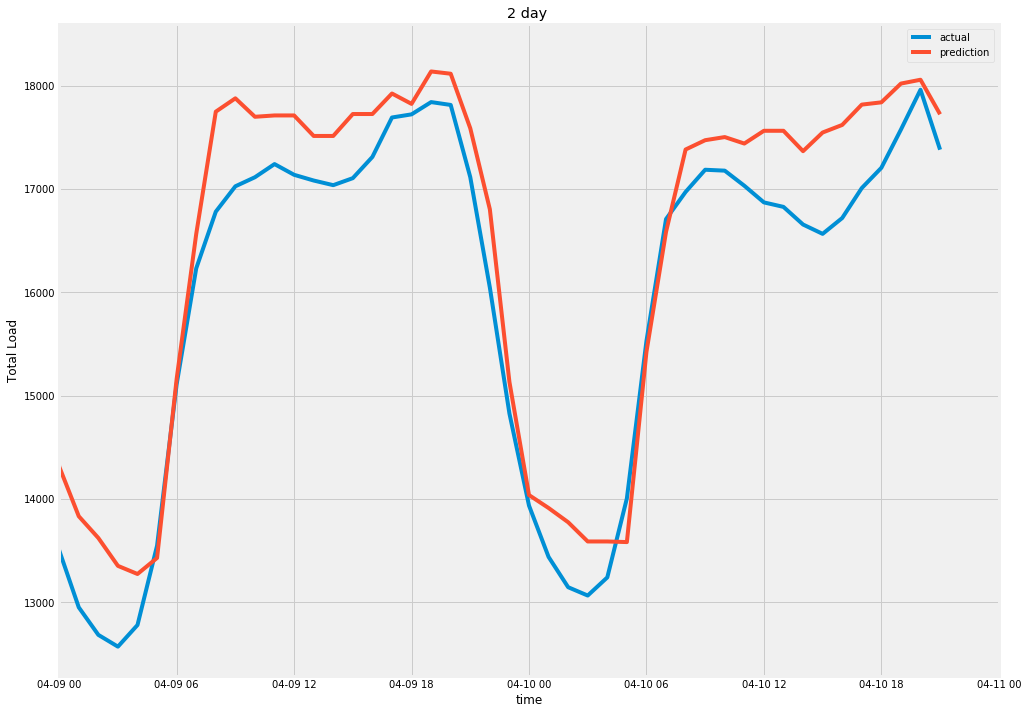

In [127]:
plt.figure(figsize=(15,12))
plt.xlabel('time')
plt.ylabel('Total Load')
plt.title("2 day ")
plt.plot(x_, act_, '-', label='actual')
plt.plot(x_, day_fcst, '-', label='prediction')
plt.legend()
plt.xlim(left='04-09-2019', right='04-11-2019')
plt.show()

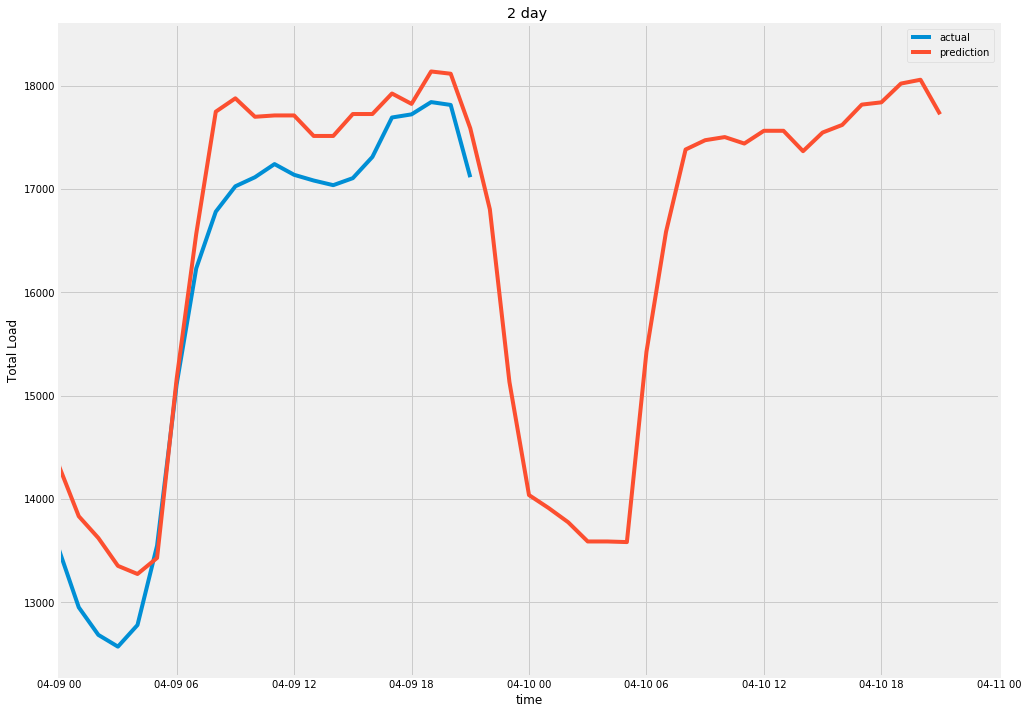

In [128]:
plt.figure(figsize=(15,12))
plt.xlabel('time')
plt.ylabel('Total Load')
plt.title("2 day ")
plt.plot(x_2, act_2, '-', label='actual')
plt.plot(x_, day_fcst, '-', label='prediction')
plt.legend()
plt.xlim(left='04-09-2019', right='04-11-2019')
plt.show()